In [1]:
%matplotlib inline
#%matplotlib widget


import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

# Standardization
from sklearn.preprocessing import StandardScaler

#CV
from sklearn import model_selection
from sklearn.model_selection import cross_validate

#models
from sklearn.linear_model import Ridge  # it's linear regression with l2 regularization

#model metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv('https://hastie.su.domains/ElemStatLearn/datasets/SAheart.data?fbclid=IwAR0bnadUy7l7_jwPgJzAW1Dg5RM_JyAKv_doOWxuP2Fx2XpkTAliWHRl73U') 

# Regression, part A

#### Data cleaning

In [3]:
# drop unnecessary name variable
data.drop(columns = 'row.names',inplace=True)
# one hot enc of categorical variable famhist
df_famhist = pd.get_dummies(data['famhist'],prefix="famhist")
data.drop(columns = 'famhist',inplace=True)
data = pd.concat([data, df_famhist], axis=1)

df_chd = pd.get_dummies(data['chd'],prefix="chd")
data.drop(columns = 'chd',inplace=True)
data = pd.concat([data, df_chd], axis=1)


print(f'Columns: {list(data.columns)}')

Columns: ['sbp', 'tobacco', 'ldl', 'adiposity', 'typea', 'obesity', 'alcohol', 'age', 'famhist_Absent', 'famhist_Present', 'chd_0', 'chd_1']


In [4]:
X = data.iloc[:,[0,1,2,4,5,6,7,8,9,10,11]]
X_data_columns = X.columns
y = data.iloc[:,[3]]

In [5]:
X = StandardScaler().fit_transform(X)
#X = X.to_numpy()
y = StandardScaler().fit_transform(y)

#y = y.to_numpy()


#### Model

##### Cross validation

In [6]:
K = 10
CV = model_selection.KFold(K, shuffle=True)

In [7]:
scoring_ = make_scorer(mean_squared_error, greater_is_better = False)

In [8]:
optimal_lambda = None
mean_training_err_per_lambda = []
mean_generalization_err_per_lambda = []
mean_coefs_per_lambda = []

lambdas = np.power(10.,range(-5,9))
#lambdas = [1,10,100,1000,1000]
mean_training_err_per_lambda_value = []
mean_generalization_err_per_lambda_value = []
for lambda_value in lambdas:
    model_r = Ridge(alpha=lambda_value)
    result = cross_validate(model_r, X=X, y=y, cv=CV, scoring=scoring_, return_estimator=True, return_train_score=True,verbose=0)

    # info for the coef weights so that we can make the plot afterwards
    coefs = []
    for est in result['estimator']:
        coefs.append(est.coef_)
    mean_coefs_per_lambda.append(np.array(
    coefs).mean(axis=0))
    
    mean_training_err_per_lambda.append(abs(result['train_score'].mean()))
    mean_generalization_err_per_lambda.append(abs(result['test_score'].mean()))
optimal_lambda = lambdas[np.argmin(mean_generalization_err_per_lambda)]


In [9]:
print(f'Optimal lambda: {optimal_lambda}')

Optimal lambda: 0.001


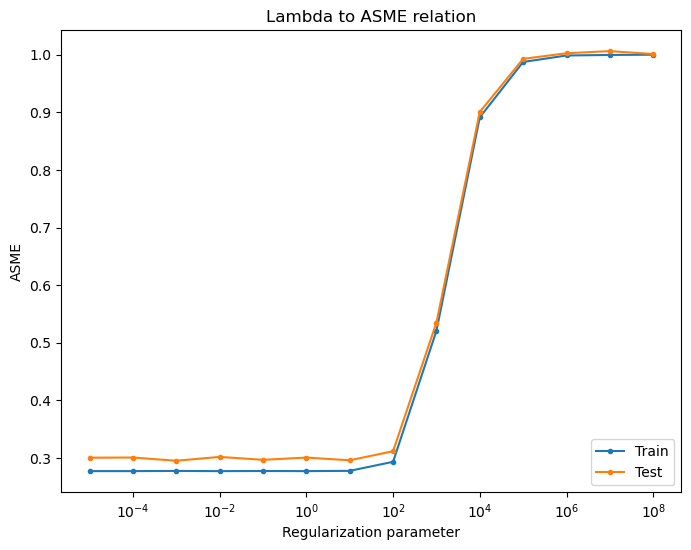

In [10]:
# Lambda to ASME relation
plt.rcParams["figure.figsize"] = (8,6)

plt.semilogx(lambdas, mean_training_err_per_lambda, label="Train", marker = ".")
plt.semilogx(lambdas, mean_generalization_err_per_lambda, label="Test", marker = "." )
plt.legend(loc="lower right")
plt.xlabel("Regularization parameter")
plt.ylabel("ASME")
plt.title("Lambda to ASME relation")
plt.show()

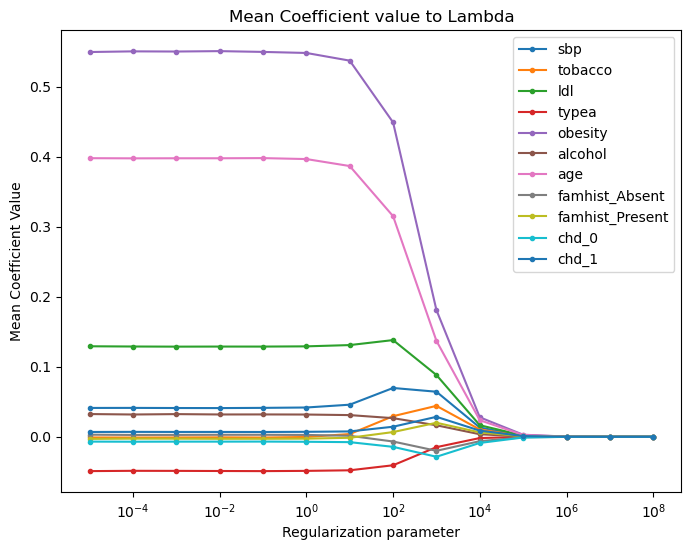

In [11]:
# Mean attribute coef to Lambda value
plt.rcParams["figure.figsize"] = (8,6)

for i in range(len(X_data_columns)):
    ys = []
    for coef in mean_coefs_per_lambda:
        ys.append(coef[0][i])
    plt.semilogx(lambdas,ys, label=X_data_columns[i] ,marker='.')


#plt.legend(loc="top right")
plt.legend()
plt.xlabel("Regularization parameter")
plt.ylabel("Mean Coefficient Value")
plt.title("Mean Coefficient value to Lambda")
plt.show()

In [12]:
final_model_r = model_r = Ridge(alpha=optimal_lambda)
final_model_r.fit(X,y)
print(list(zip(final_model_r.coef_[0],X_data_columns)))

[(0.04142867280943753, 'sbp'), (-0.000915528125878996, 'tobacco'), (0.12893191039105262, 'ldl'), (-0.04872962949280864, 'typea'), (0.5493622622087313, 'obesity'), (0.03194791447797771, 'alcohol'), (0.39774468299281257, 'age'), (0.002750230460706359, 'famhist_Absent'), (-0.00275023036966149, 'famhist_Present'), (-0.006850746129636775, 'chd_0'), (0.006850746154592599, 'chd_1')]


# Regression, part b

In [13]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
import torch
from sklearn.metrics import mean_squared_error

In [14]:
def train_neural_net(model, loss_fn, X, y,
                     n_replicates=3, max_iter = 10000, tolerance=1e-6):
    """
    Train a neural network with PyTorch based on a training set consisting of
    observations X and class y. The model and loss_fn inputs define the
    architecture to train and the cost-function update the weights based on,
    respectively.
    
    Usage:
        Assuming loaded dataset (X,y) has been split into a training and 
        test set called (X_train, y_train) and (X_test, y_test), and
        that the dataset has been cast into PyTorch tensors using e.g.:
            X_train = torch.tensor(X_train, dtype=torch.float)
        Here illustrating a binary classification example based on e.g.
        M=2 features with H=2 hidden units:
    
        >>> # Define the overall architechture to use
        >>> model = lambda: torch.nn.Sequential( 
                    torch.nn.Linear(M, H),  # M features to H hiden units
                    torch.nn.Tanh(),        # 1st transfer function
                    torch.nn.Linear(H, 1),  # H hidden units to 1 output neuron
                    torch.nn.Sigmoid()      # final tranfer function
                    ) 
        >>> loss_fn = torch.nn.BCELoss() # define loss to use
        >>> net, final_loss, learning_curve = train_neural_net(model,
                                                       loss_fn,
                                                       X=X_train,
                                                       y=y_train,
                                                       n_replicates=3)
        >>> y_test_est = net(X_test) # predictions of network on test set
        >>> # To optain "hard" class predictions, threshold the y_test_est
        >>> See exercise ex8_2_2.py for indepth example.
        
        For multi-class with C classes, we need to change this model to e.g.:
        >>> model = lambda: torch.nn.Sequential(
                            torch.nn.Linear(M, H), #M features to H hiden units
                            torch.nn.ReLU(), # 1st transfer function
                            torch.nn.Linear(H, C), # H hidden units to C classes
                            torch.nn.Softmax(dim=1) # final tranfer function
                            )
        >>> loss_fn = torch.nn.CrossEntropyLoss()
        
        And the final class prediction is based on the argmax of the output
        nodes:
        >>> y_class = torch.max(y_test_est, dim=1)[1]
        
    Args:
        model:          A function handle to make a torch.nn.Sequential.
        loss_fn:        A torch.nn-loss, e.g.  torch.nn.BCELoss() for binary 
                        binary classification, torch.nn.CrossEntropyLoss() for
                        multiclass classification, or torch.nn.MSELoss() for
                        regression (see https://pytorch.org/docs/stable/nn.html#loss-functions)
        n_replicates:   An integer specifying number of replicates to train,
                        the neural network with the lowest loss is returned.
        max_iter:       An integer specifying the maximum number of iterations
                        to do (default 10000).
        tolerenace:     A float describing the tolerance/convergence criterion
                        for minimum relative change in loss (default 1e-6)
                        
        
    Returns:
        A list of three elements:
            best_net:       A trained torch.nn.Sequential that had the lowest 
                            loss of the trained replicates
            final_loss:     An float specifying the loss of best performing net
            learning_curve: A list containing the learning curve of the best net.
    
    """
    
    import torch
    # Specify maximum number of iterations for training
    logging_frequency = 1000 # display the loss every 1000th iteration
    best_final_loss = 1e100
    for r in range(n_replicates):
        #print('\n\tReplicate: {}/{}'.format(r+1, n_replicates))
        # Make a new net (calling model() makes a new initialization of weights) 
        net = model()
        
        # initialize weights based on limits that scale with number of in- and
        # outputs to the layer, increasing the chance that we converge to 
        # a good solution
        torch.nn.init.xavier_uniform_(net[0].weight)
        torch.nn.init.xavier_uniform_(net[2].weight)
                     
        # We can optimize the weights by means of stochastic gradient descent
        # The learning rate, lr, can be adjusted if training doesn't perform as
        # intended try reducing the lr. If the learning curve hasn't converged
        # (i.e. "flattend out"), you can try try increasing the maximum number of
        # iterations, but also potentially increasing the learning rate:
        #optimizer = torch.optim.SGD(net.parameters(), lr = 5e-3)
        
        # A more complicated optimizer is the Adam-algortihm, which is an extension
        # of SGD to adaptively change the learing rate, which is widely used:
        optimizer = torch.optim.Adam(net.parameters())
        
        # Train the network while displaying and storing the loss
        #print('\t\t{}\t{}\t\t\t{}'.format('Iter', 'Loss','Rel. loss'))
        learning_curve = [] # setup storage for loss at each step
        old_loss = 1e6
        for i in range(max_iter):
            y_est = net(X) # forward pass, predict labels on training set
            loss = loss_fn(y_est, y) # determine loss
            loss_value = loss.data.numpy() #get numpy array instead of tensor
            learning_curve.append(loss_value) # record loss for later display
            
            # Convergence check, see if the percentual loss decrease is within
            # tolerance:
            p_delta_loss = np.abs(loss_value-old_loss)/old_loss
            if p_delta_loss < tolerance: break
            old_loss = loss_value
            
            # display loss with some frequency:
            if (i != 0) & ((i+1) % logging_frequency == 0):
                print_str = '\t\t' + str(i+1) + '\t' + str(loss_value) + '\t' + str(p_delta_loss)
                #print(print_str)
            # do backpropagation of loss and optimize weights 
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            
            
        # display final loss
        #print('\t\tFinal loss:')
        print_str = '\t\t' + str(i+1) + '\t' + str(loss_value) + '\t' + str(p_delta_loss)
        #print(print_str)
        
        if loss_value < best_final_loss: 
            best_net = net
            best_final_loss = loss_value
            best_learning_curve = learning_curve
        
    # Return the best curve along with its final loss and learing curve
    return best_net, best_final_loss, best_learning_curve

In [15]:
model_reg_1 = DummyRegressor()
model_reg_2 = Ridge()
#model_reg_3 =  None

In [16]:
param_grid_1 = [{'strategy': ["mean"]}]
param_grid_2 = [{'alpha': np.power(10., np.arange(-5, 9))}]

scoring_ = make_scorer(mean_squared_error, greater_is_better=False)

In [40]:
#inner
K = 10
cv_inner = model_selection.KFold(K, shuffle=True)

gridcvs = {}

for pgrid, est, name in zip((param_grid_1, param_grid_2),
                            (model_reg_1, model_reg_2),
                            ('Baseline', 'Regularized Regression')):
    
    gcv = GridSearchCV(estimator=est,
                   param_grid=pgrid,
                   scoring= scoring_,
                   n_jobs=-1,
                   cv=cv_inner,
                   verbose=0,
                   refit=True)
    gridcvs[name] = gcv

In [59]:
K = 10
cv_outer = model_selection.KFold(K, shuffle=True)
inner_models = {}
ANN_models = {'inner': [], 'outer': []}
model_names = list(gridcvs.keys())
for name in model_names:
    #inner will store all the results of the inner CV and outer will store only MSE for each outer CV
    inner_models[name] = {'inner': [], 'outer': []}


for index, train_test_idxs in enumerate(cv_outer.split(X, y)):
    train_idx, test_idx = train_test_idxs
    print(f'Fold {index+1}')
    for name, gs_est in sorted(gridcvs.items()):

            gridcvs[name].fit(X[train_idx], y[train_idx]) # run inner loop hyperparam tuning
            info_dict = gridcvs[name].cv_results_
            info_dict['best_params_'] = gridcvs[name].best_params_
            
            inner_models[name]['inner'].append(info_dict)
            #print('      Best mean square error: %.2f' % (gridcvs[name].best_score_), end='\t')
            #print('      Best parameters:', gridcvs[name].best_params_ )       

            y_pred = gridcvs[name].best_estimator_.predict(X[test_idx])
            MSE = mean_squared_error(y[test_idx], y_pred)
            inner_models[name]['outer'].append(MSE)

    #ANN
    
    X2 = X [train_idx]
    y2 = y[train_idx]
    each_iteration_info = []
    
    for index_inner, train_test_idxs_inner in enumerate(cv_inner.split(X2, y2)):
        train_idx_inner, test_idx_inner = train_test_idxs_inner
        
        M = len(X_data_columns)
        n_hidden_units = [1,5,10,50,100,500]
        each_iteration_info = []
        for h in n_hidden_units:
            model = lambda: torch.nn.Sequential(
                                torch.nn.Linear(M, h), #M features to H hiden units
                                # 1st transfer function, either Tanh or ReLU:
                                torch.nn.ReLU(),                            #torch.nn.Tanh(),
                                torch.nn.Linear(h, 1), # H hidden units to 1 output neuron
                                )
            loss_fn = torch.nn.MSELoss()   #loss_fn = torch.nn.BCELoss()
            max_iter = 1000

            X_train = torch.Tensor(X2[train_idx_inner,:])
            y_train = torch.Tensor(y2[train_idx_inner])
            X_test = torch.Tensor(X2[test_idx_inner,:])
            y_test = torch.Tensor(y2[test_idx_inner])

            net, final_loss, learning_curve = train_neural_net(model,
                                                               loss_fn,
                                                               X=X_train,
                                                               y=y_train,
                                                               n_replicates=1,
                                                               max_iter=max_iter)

            each_iteration_info.append((net, final_loss, learning_curve, net[0].out_features))
        each_iteration_info = sorted(each_iteration_info, key=lambda x: x[1])
        
        ANN_models['inner'].append(each_iteration_info[0])
        y_pred = ANN_models['inner'][index_inner][0](X_test)

    MSE = mean_squared_error(y_test, y_pred.detach().numpy())
    ANN_models['outer'].append(MSE)


Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10


In [60]:
model_names.append("ANN")
for name in model_names:
    print(name)
    for index in range(K):
        print(f'\t Fold_{index+1}' , end='\t')
        if name!="ANN":
            print(inner_models[name]['inner'][index]['best_params_'] , end='\t')
            print(f' SME: {inner_models[name]["outer"][index]}')
        else:
            print(f' h: {ANN_models["inner"][index][3]}' , end='\t')
            print(f' SME: {ANN_models["outer"][index]}')


Baseline
	 Fold_1	{'strategy': 'mean'}	 SME: 1.0897031371804144
	 Fold_2	{'strategy': 'mean'}	 SME: 0.7623110384936033
	 Fold_3	{'strategy': 'mean'}	 SME: 0.8702864958865874
	 Fold_4	{'strategy': 'mean'}	 SME: 1.039619699602162
	 Fold_5	{'strategy': 'mean'}	 SME: 1.069860905564758
	 Fold_6	{'strategy': 'mean'}	 SME: 0.7736460036674006
	 Fold_7	{'strategy': 'mean'}	 SME: 0.9148083737873322
	 Fold_8	{'strategy': 'mean'}	 SME: 0.954166526769124
	 Fold_9	{'strategy': 'mean'}	 SME: 1.1269779353060188
	 Fold_10	{'strategy': 'mean'}	 SME: 1.4132550981353595
Regularized Regression
	 Fold_1	{'alpha': 10.0}	 SME: 0.3209958445351176
	 Fold_2	{'alpha': 10.0}	 SME: 0.2162564945178428
	 Fold_3	{'alpha': 10.0}	 SME: 0.22985987494583685
	 Fold_4	{'alpha': 10.0}	 SME: 0.19124644851580969
	 Fold_5	{'alpha': 10.0}	 SME: 0.20155896538998674
	 Fold_6	{'alpha': 10.0}	 SME: 0.20378640885542443
	 Fold_7	{'alpha': 10.0}	 SME: 0.5971491134154172
	 Fold_8	{'alpha': 10.0}	 SME: 0.3366740676441824
	 Fold_9	{'alpha

In [61]:
gen_err_ANN = np.array(ANN_models["outer"][:])
gen_err_baseline = np.array(inner_models["Baseline"]["outer"][:])
gen_err_regr = np.array(inner_models["Regularized Regression"]["outer"][:])
print(f'gen_err_ANN: {gen_err_ANN}')
print(f'gen_err_baseline: {gen_err_baseline}')
print(f'gen_err_regr: {gen_err_regr}')

gen_err_ANN: [0.71571404 0.08367702 0.13523318 0.06853125 0.23747589 0.1666076
 0.15241987 0.14028011 0.23956466 0.20296897]
gen_err_baseline: [1.08970314 0.76231104 0.8702865  1.0396197  1.06986091 0.773646
 0.91480837 0.95416653 1.12697794 1.4132551 ]
gen_err_regr: [0.32099584 0.21625649 0.22985987 0.19124645 0.20155897 0.20378641
 0.59714911 0.33667407 0.35138066 0.27759369]


### Statistical comparison

In [62]:
import scipy.stats as st

In [63]:
#Regularized regression-Baseline
z =    gen_err_regr - gen_err_baseline
#print(z)
alpha = 0.05

CI = st.t.interval(1-alpha, len(z)-1, loc=np.mean(z), scale=st.sem(z))  # Confidence interval
p = 2*st.t.cdf( -np.abs( np.mean(z) )/st.sem(z), df=len(z)-1)  # p-value

print("Regularized regression - Baseline")
print(f'p value: {p}')
print(f'Confidence interval: {CI}')


#Regularized regression-ANN
z =    gen_err_regr - gen_err_ANN
#print(z)
alpha = 0.05

CI = st.t.interval(1-alpha, len(z)-1, loc=np.mean(z), scale=st.sem(z))  # Confidence interval
p = 2*st.t.cdf( -np.abs( np.mean(z) )/st.sem(z), df=len(z)-1)  # p-value

print("Regularized regression - ANN")
print(f'p value: {p}')
print(f'Confidence interval: {CI}')


#ANN-Baseline
z =    gen_err_ANN - gen_err_baseline
#print(z)
alpha = 0.05

CI = st.t.interval(1-alpha, len(z)-1, loc=np.mean(z), scale=st.sem(z))  # Confidence interval
p = 2*st.t.cdf( -np.abs( np.mean(z) )/st.sem(z), df=len(z)-1)  # p-value

print("ANN - Baseline")
print(f'p value: {p}')
print(f'Confidence interval: {CI}')


Regularized regression - Baseline
p value: 3.4100554406241645e-06
Confidence interval: (-0.8682337643335303, -0.5493929641355455)
Regularized regression - ANN
p value: 0.2658232941189464
Confidence interval: (-0.07108625214552297, 0.22789204904983032)
ANN - Baseline
p value: 1.3737094099966793e-06
Confidence interval: (-0.9460935603945887, -0.6283389649787944)


# Classicfication

We are going to predict the CHD attribute and it's a binary classification problem.

In [83]:
from sklearn.linear_model  import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score


In [202]:
data = pd.read_csv('https://hastie.su.domains/ElemStatLearn/datasets/SAheart.data?fbclid=IwAR0bnadUy7l7_jwPgJzAW1Dg5RM_JyAKv_doOWxuP2Fx2XpkTAliWHRl73U') 

#### cleaning

In [203]:
# drop unnecessary name variable
data.drop(columns = 'row.names',inplace=True)
# one hot enc of categorical variable famhist
df_famhist = pd.get_dummies(data['famhist'],prefix="famhist")
data.drop(columns = 'famhist',inplace=True)
data = pd.concat([data, df_famhist], axis=1)
print(f'Columns: {list(data.columns)}')

Columns: ['sbp', 'tobacco', 'ldl', 'adiposity', 'typea', 'obesity', 'alcohol', 'age', 'chd', 'famhist_Absent', 'famhist_Present']


In [204]:
X = data.iloc[:,[0,1,2,3,4,5,6,7,9,10]]
X_data_columns = X.columns
y = data.iloc[:,[8]]

In [205]:
X = StandardScaler().fit_transform(X)
#y = StandardScaler().fit_transform(y)
y = y.to_numpy()

In [206]:
model_reg_1 = DummyClassifier(strategy="most_frequent")
model_reg_2 = LogisticRegression()
#model_reg_3 =  None

In [227]:
param_grid_1 = [{'strategy': ["most_frequent"]}]
param_grid_2 = [{'C': 1/np.array([0.1,0.5,1,1.5,4,10,25,100])}]  # c = 1/alpha


def my_custom_loss_func(ground_truth, predictions):
    acc = accuracy_score(ground_truth,predictions)
    return 1 - acc

scoring_ = make_scorer(my_custom_loss_func, greater_is_better=False)

In [267]:
#inner
K = 2
cv_inner = model_selection.KFold(K, shuffle=True)

gridcvs = {}

for pgrid, est, name in zip((param_grid_1, param_grid_2),
                            (model_reg_1, model_reg_2),
                            ('Baseline', 'Regularized Logistic Regression')):

    gcv = GridSearchCV(estimator=est,
                   param_grid=pgrid,
                   scoring= scoring_,
                   n_jobs=-1,
                   cv=cv_inner,
                   verbose=0,
                   refit=True)
    gridcvs[name] = gcv

In [268]:
K = 2
cv_outer = model_selection.KFold(K, shuffle=True)
inner_models = {}
ANN_models = {'inner': [], 'outer': []}
model_names = list(gridcvs.keys())
for name in model_names:
    #inner will store all the results of the inner CV and outer will store only MSE for each outer CV
    inner_models[name] = {'inner': [], 'outer': []}


for index, train_test_idxs in enumerate(cv_outer.split(X, y)):
    train_idx, test_idx = train_test_idxs
    print(f'Fold {index+1}')
    for name, gs_est in sorted(gridcvs.items()):
            gridcvs[name].fit(X[train_idx], y[train_idx].ravel() ) # run inner loop hyperparam tuning
            info_dict = gridcvs[name].cv_results_
#             print( gridcvs[name].cv_results_)
#             input()
            info_dict['best_params_'] = gridcvs[name].best_params_
            
            inner_models[name]['inner'].append(info_dict)
            #print('      Best error rate: %.2f' % (abs(gridcvs[name].best_score_)), end='\t')
            #print('      Best parameters:', gridcvs[name].best_params_ )       
            y_pred = gridcvs[name].best_estimator_.predict(X[test_idx])
            error_rate = round(my_custom_loss_func(y[test_idx], y_pred),3)
            inner_models[name]['outer'].append(error_rate)
#             MSE = mean_squared_error(y[test_idx], y_pred)
#             inner_models[name]['outer'].append(MSE)




  #ANN
    
    X2 = X [train_idx]
    y2 = y[train_idx]
    each_iteration_info = []
    
    for index_inner, train_test_idxs_inner in enumerate(cv_inner.split(X2, y2)):
        train_idx_inner, test_idx_inner = train_test_idxs_inner
        
        M = len(X_data_columns)
        n_hidden_units = [1,5,10,50,100,500]
        each_iteration_info = []
        for h in n_hidden_units:
            model = lambda: torch.nn.Sequential(
                                torch.nn.Linear(M, h), #M features to H hiden units
                                # 1st transfer function, either Tanh or ReLU:
                                torch.nn.ReLU(),                            #torch.nn.Tanh(),
                                torch.nn.Linear(h, 1), # H hidden units to 1 output neuron
                                torch.nn.Sigmoid()
                                )

            # Since we're training a neural network for binary classification, we use a 
            # binary cross entropy loss (see the help(train_neural_net) for more on
            # the loss_fn input to the function)
            loss_fn = torch.nn.BCELoss()
            max_iter = 10

            X_train = torch.Tensor(X2[train_idx_inner,:])
            y_train = torch.Tensor(y2[train_idx_inner])
            X_test = torch.Tensor(X2[test_idx_inner,:])
            y_test = torch.Tensor(y2[test_idx_inner])

            net, final_loss, learning_curve = train_neural_net(model,
                                                               loss_fn,
                                                               X=X_train,
                                                               y=y_train,
                                                               n_replicates=1,
                                                               max_iter=max_iter)

            each_iteration_info.append((net, final_loss, learning_curve, net[0].out_features))
        each_iteration_info = sorted(each_iteration_info, key=lambda x: x[1] , reverse=True)
        print(each_iteration_info)
        ANN_models['inner'].append(each_iteration_info[0])
        
        
        #WORKING HERE ATM
        # Determine estimated class labels for test set
        y_sigmoid = ANN_models['inner'][index_inner][0](X_test) # activation of final note, i.e. prediction of network
        y_test_est = (y_sigmoid > .5).type(dtype=torch.uint8) # threshold output of sigmoidal function
        y_test = y_test.type(dtype=torch.uint8)
        # Determine errors and error rate
        e = (y_test_est != y_test)
        error_rate = (sum(e).type(torch.float)/len(y_test)).data.numpy()
    error_rate = mean_squared_error(y_test, y_pred.detach().numpy())
    ANN_models['outer'].append(MSE)

Fold 1
[(Sequential(
  (0): Linear(in_features=10, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=1, bias=True)
  (3): Sigmoid()
), array(1.1517581, dtype=float32), [array(1.210369, dtype=float32), array(1.2036307, dtype=float32), array(1.1969767, dtype=float32), array(1.1903864, dtype=float32), array(1.1838475, dtype=float32), array(1.1773456, dtype=float32), array(1.1708914, dtype=float32), array(1.1644752, dtype=float32), array(1.158097, dtype=float32), array(1.1517581, dtype=float32)], 10), (Sequential(
  (0): Linear(in_features=10, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=1, bias=True)
  (3): Sigmoid()
), array(0.7042693, dtype=float32), [array(0.7886934, dtype=float32), array(0.7783689, dtype=float32), array(0.7682759, dtype=float32), array(0.758431, dtype=float32), array(0.7488206, dtype=float32), array(0.7394303, dtype=float32), array(0.7302781, dtype=float32), array(0.72137046, dtype=float32), ar

KeyboardInterrupt: Interrupted by user

In [264]:
#model_names.append("ANN")
for name in model_names:
    print(name)
    for index in range(K):
        print(f'\t Fold_{index+1}' , end='\t')
        if name!="ANN":
            print(inner_models[name]['inner'][index]['best_params_'] , end='\t')
            print(f' error rate: {inner_models[name]["outer"][index]}')
        else:
            print(f' h: {ANN_models["inner"][index][3]}' , end='\t')
            print(f' error rate: {ANN_models["outer"][index]}')

Baseline
	 Fold_1	{'strategy': 'most_frequent'}	 error rate: 0.277
	 Fold_2	{'strategy': 'most_frequent'}	 error rate: 0.468
	 Fold_3	{'strategy': 'most_frequent'}	 error rate: 0.283
	 Fold_4	{'strategy': 'most_frequent'}	 error rate: 0.391
	 Fold_5	{'strategy': 'most_frequent'}	 error rate: 0.326
	 Fold_6	{'strategy': 'most_frequent'}	 error rate: 0.348
	 Fold_7	{'strategy': 'most_frequent'}	 error rate: 0.326
	 Fold_8	{'strategy': 'most_frequent'}	 error rate: 0.326
	 Fold_9	{'strategy': 'most_frequent'}	 error rate: 0.283
	 Fold_10	{'strategy': 'most_frequent'}	 error rate: 0.435
Regularized Logistic Regression
	 Fold_1	{'C': 10.0}	 error rate: 0.149
	 Fold_2	{'C': 10.0}	 error rate: 0.277
	 Fold_3	{'C': 0.04}	 error rate: 0.304
	 Fold_4	{'C': 0.04}	 error rate: 0.174
	 Fold_5	{'C': 0.04}	 error rate: 0.37
	 Fold_6	{'C': 0.04}	 error rate: 0.239
	 Fold_7	{'C': 0.04}	 error rate: 0.391
	 Fold_8	{'C': 0.04}	 error rate: 0.196
	 Fold_9	{'C': 0.04}	 error rate: 0.304
	 Fold_10	{'C': 0.1

In [265]:
#gen_err_ANN = np.array(ANN_models["outer"][:])
gen_err_baseline = np.array(inner_models["Baseline"]["outer"][:])
gen_err_regr = np.array(inner_models["Regularized Logistic Regression"]["outer"][:])
#print(f'gen_err_ANN: {gen_err_ANN}')
print(f'gen_err_baseline: {gen_err_baseline}')
print(f'gen_err_regr: {gen_err_regr}')

gen_err_baseline: [0.277 0.468 0.283 0.391 0.326 0.348 0.326 0.326 0.283 0.435]
gen_err_regr: [0.149 0.277 0.304 0.174 0.37  0.239 0.391 0.196 0.304 0.239]


In [266]:
#Regularized Logistic regression-Baseline
z =    gen_err_regr - gen_err_baseline
#print(z)
alpha = 0.05

CI = st.t.interval(1-alpha, len(z)-1, loc=np.mean(z), scale=st.sem(z))  # Confidence interval
p = 2*st.t.cdf( -np.abs( np.mean(z) )/st.sem(z), df=len(z)-1)  # p-value

print("Regularized regression - Baseline")
print(f'p value: {p}')
print(f'Confidence interval: {CI}')


# #Regularized regression-ANN
# z =    gen_err_regr - gen_err_ANN
# #print(z)
# alpha = 0.05

# CI = st.t.interval(1-alpha, len(z)-1, loc=np.mean(z), scale=st.sem(z))  # Confidence interval
# p = 2*st.t.cdf( -np.abs( np.mean(z) )/st.sem(z), df=len(z)-1)  # p-value

# print("Regularized Logistic regression - ANN")
# print(f'p value: {p}')
# print(f'Confidence interval: {CI}')


# #ANN-Baseline
# z =    gen_err_ANN - gen_err_baseline
# #print(z)
# alpha = 0.05

# CI = st.t.interval(1-alpha, len(z)-1, loc=np.mean(z), scale=st.sem(z))  # Confidence interval
# p = 2*st.t.cdf( -np.abs( np.mean(z) )/st.sem(z), df=len(z)-1)  # p-value

# print("ANN - Baseline")
# print(f'p value: {p}')
# print(f'Confidence interval: {CI}')

Regularized regression - Baseline
p value: 0.0413167760411042
Confidence interval: (-0.1599830173652706, -0.004016982634729396)
